In [1]:
from os.path import join

import numpy as np
from numpy.linalg import svd
from scipy.io import loadmat
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

from pydotplus import graph_from_dot_data
from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['font.size'] =  18

In [2]:
# Add handler to display decision trees using pydot
def _show_tree(dtclassifier):
    return graph_from_dot_data(
        export_graphviz(
            dtclassifier, out_file=None,  
            filled=True, rounded=True,
            special_characters=True
        )
    ).create_png()

DecisionTreeClassifier._repr_png_ = _show_tree

In [3]:
# Iris data
iris = load_iris()
measurements, species = iris['data'], iris['target_names'][iris['target']]

x1 = measurements[species == 'setosa', :]
x2 = measurements[species == 'versicolor', :]
x3 = measurements[species == 'virginica', :]

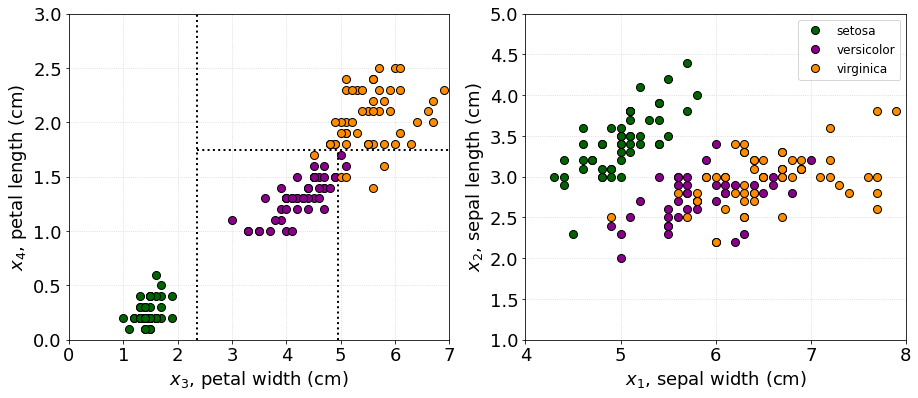

In [4]:
# Figure 5.24 (approx)

## Splitting Procedure

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(x1[:, 2], x1[:, 3], 'o', markerfacecolor='darkgreen', markeredgecolor='black', ms=8)
axs[0].plot(x2[:, 2], x2[:, 3], 'o', markerfacecolor='darkmagenta', markeredgecolor='black', ms=8)
axs[0].plot(x3[:, 2], x3[:, 3], 'o', markerfacecolor='darkorange', markeredgecolor='black', ms=8)

axs[0].plot([2.35, 2.35], [0, 3], ':', color='black', linewidth=2)
axs[0].plot([2.35, 10], [1.75, 1.75], ':', color='black', linewidth=2)
axs[0].plot([4.95, 4.95], [0, 1.75], ':', color='black', linewidth=2)

axs[0].set_xlim(0, 7)
axs[0].set_ylim(0, 3)
axs[0].set_xlabel('$x_3$, petal width (cm)')
axs[0].set_ylabel('$x_4$, petal length (cm)')

axs[0].grid(True, linestyle=':', color='lightgray')

axs[1].plot(x1[:, 0], x1[:, 1], 'o', markerfacecolor='darkgreen', markeredgecolor='black', ms=8, label='setosa')
axs[1].plot(x2[:, 0], x2[:, 1], 'o', markerfacecolor='darkmagenta', markeredgecolor='black', ms=8, label='versicolor')
axs[1].plot(x3[:, 0], x3[:, 1], 'o', markerfacecolor='darkorange', markeredgecolor='black', ms=8, label='virginica')
axs[1].set_xlim(4, 8)
axs[1].set_ylim(1, 5)
axs[1].set_xlabel('$x_1$, sepal width (cm)')
axs[1].set_ylabel('$x_2$, sepal length (cm)')
axs[1].legend(prop={'size': 12})
axs[1].grid(True, linestyle=':', color='lightgray');

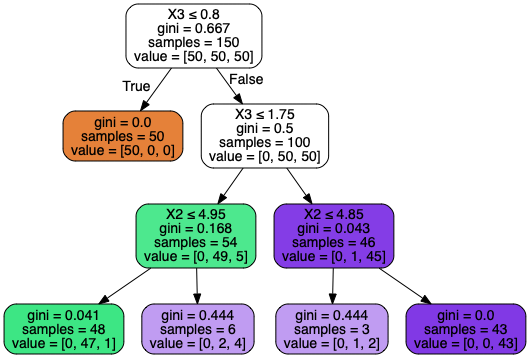

Class loss = 0.0400


In [5]:
# Figure 5.25 (approx)

labels = LabelEncoder().fit(species).transform(species)
classifier = DecisionTreeClassifier(max_depth=3).fit(measurements, labels)
display(classifier)

cross_val = cross_val_score(classifier, measurements, labels, cv=10) # cross-validate the model
class_loss = 1 - np.mean(cross_val) # average error over all cross-validation iterations

print(f'Class loss = {class_loss:0.4f}')

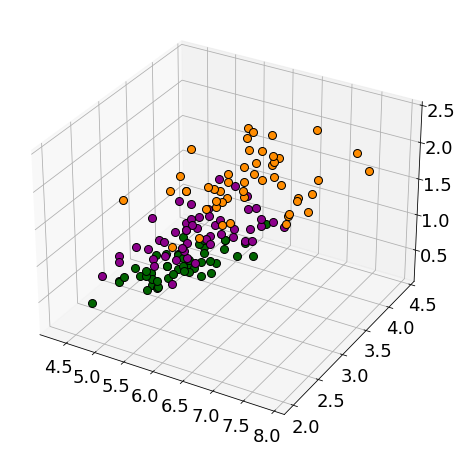

In [6]:
cols = [0, 1, 3]
xs = [x1[:, cols], x2[:, cols], x3[:, cols]]
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': '3d'})
for x, color in zip(xs, ['darkgreen', 'darkmagenta', 'darkorange']):
    ax.plot(*x.T, 'o', markerfacecolor=color, markeredgecolor='black', ms=8)

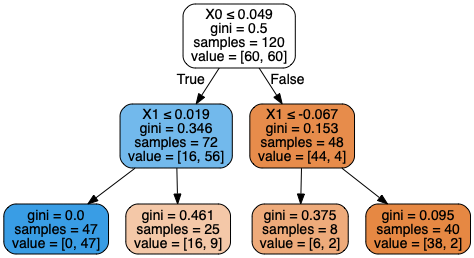

Class loss = 0.1500


In [7]:
# Wavelet encoded Cats vs Dogs images
# Figure 5.26 (approx)

dogdata_w_mat = loadmat(join('..', 'DATA', 'dogData_w.mat'))
catdata_w_mat = loadmat(join('..', 'DATA', 'catData_w.mat'))

dog_wave = dogdata_w_mat['dog_wave']
cat_wave = catdata_w_mat['cat_wave']

_, nimages = dog_wave.shape

CD = np.hstack((dog_wave, cat_wave))

U, S, VT = svd(CD - CD.mean(), full_matrices=False)
V = VT.T

ntrain = 60
ntest = nimages - ntrain
modes = [2, 4]
cols = np.array(modes) - 1

train = np.vstack((
    V[:ntrain, cols],
    V[nimages:nimages+ntrain, cols]
))
labels = np.repeat([1, -1], ntrain)
test = np.vstack((
    V[ntrain:nimages, cols],
    V[nimages+ntrain:, cols]
))

classifier = DecisionTreeClassifier(max_depth=2).fit(train, labels)
display(classifier)

cross_val = cross_val_score(classifier, train, labels, cv=10) # cross-validate the model
class_loss = 1 - np.mean(cross_val) # average error over all cross-validation iterations

print(f'Class loss = {class_loss:0.4f}')

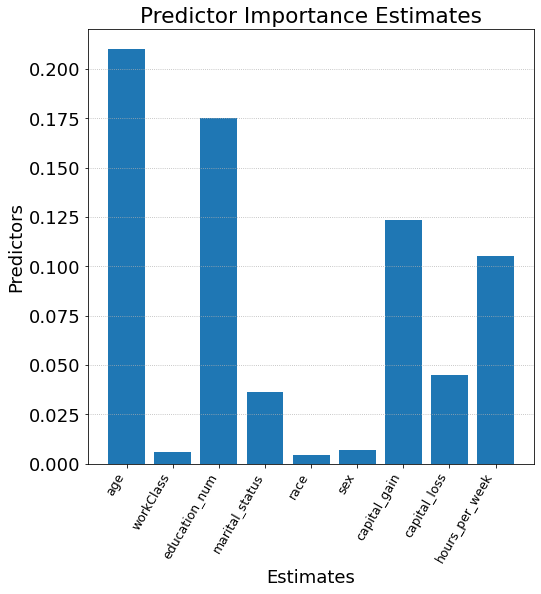

In [8]:
## Census Data

# Figure 5.27

features = ['age', 'workClass', 'education_num', 'marital_status', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week']
nfeatures = len(features)

census = pd.read_csv(join('..', 'DATA', 'census1994.csv'))
census_categorical = census[features]
salary = census['salary'] == '>50K'

# Convert categorical variables to one-hot representation (note that order of columns is *not* preserved)
census_onehot = pd.get_dummies(census_categorical, columns=['workClass', 'marital_status', 'race', 'sex'], prefix_sep='!')
onehot_features = list(census_onehot)

classifier = DecisionTreeClassifier(max_features=10, random_state=42).fit(census_onehot, salary)

# Re-merge importances from features split by onehot encoding to match original feature list (including column ordering)
importances = list(zip(onehot_features, classifier.feature_importances_))
importances = [
    np.mean([v for (k, v) in importances if k == feature or k.startswith(feature + '!')])
    for feature in features
]

fig, ax = plt.subplots(figsize=(8, 8))
ax.bar(range(nfeatures), importances)
ax.set_xticks(ticks=range(nfeatures))
ax.set_xticklabels(features, size='x-small', ha='right', rotation=60)
ax.set_xlabel('Estimates')
ax.set_ylabel('Predictors')
ax.set_title('Predictor Importance Estimates')
ax.grid(axis='y', linestyle=':');